## Извлечение отношений

Подготовка данных

In [1]:
import json
import os
from collections import Counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [15]:
import gensim

In [2]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [3]:
data = json.load(open('train.json'))

In [6]:
c = Counter([len(data[k]) for k in data])

In [9]:
ent1 = []
ent2 = []

left = []
right = []
middle = []

sents = []

target = []

for key in data:

    for instance in data[key]:
        
        tokens = instance['tokens']
        sents.append(tokens)
        
        ent1.append(' '.join([tokens[i] for i in instance['h'][2][0]]))
        ent2.append(' '.join([tokens[i] for i in instance['t'][2][0]]))

        if instance['h'][2][0][0] < instance['t'][2][0][0]:
            first, second = 'h', 't'
        else:
            second, first = 'h', 't'

        first_start = instance[first][2][0][0]
        first_end = instance[first][2][0][-1]
        second_start = instance[second][2][0][0]
        second_end = instance[second][2][0][-1]

        left_context = tokens[max(0, first_start-3):first_start]
        left.append((['<START>']*(3-len(left_context))) + left_context)
        
        right_context = tokens[second_end+1:second_end+4]
        right.append(right_context + (['<END>']*(3-len(right_context))))

        middle_context = tokens[first_end+1:second_start]
        middle.append(middle_context)

        target.append(key)

In [10]:
lefts_s = [' '.join(l) for l in left]
rights_s = [' '.join(l) for l in right]
middles_s = [' '.join(l) for l in middle]

### Обучение w2v модели (данные: корпус nltk.reuters и датасет с webhose.io)

In [119]:
from nltk.corpus import reuters

In [120]:
docs=[]
for category in reuters.categories():
    for fileid in reuters.fileids(category):
        docs.append([x for x in reuters.raw(fileid).split()])

In [121]:
len(docs)

13328

In [100]:
files = os.listdir('news')

In [108]:
dirname = os.path.join(os.getcwd(), 'news')

In [109]:
documents = []
for fname in files:
    with open(os.path.join(dirname, fname), 'r', encoding='utf-8') as f:
        d = json.load(f)
        if 'text' in d.keys():
            documents.append([x for x in d['text'].split()])

In [113]:
len(documents)

164

In [123]:
docs.extend(documents)

In [124]:
len(docs)

13492

In [154]:
model = gensim.models.Word2Vec(docs)

In [182]:
DIM = 100

Подготовка эмбеддингов

In [196]:
def get_embedding(text, model, dim = DIM):
    text = text.split()
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total)
        except (KeyError, ValueError):
            continue   
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))    
    return vector     

Сначала попробуем создать отдельно эмбеддинги для каждого окна, затем сконкатенировать получившиеся матрицы:

In [197]:
X_l = np.zeros((len(lefts_s), DIM))
X_m = np.zeros((len(middles_s), DIM))
X_r = np.zeros((len(rights_s), DIM))

In [198]:
for i, text in enumerate(lefts_s):
    X_l[i] = get_embedding(text, model)

In [199]:
for i, text in enumerate(middles_s):
    X_m[i] = get_embedding(text, model)

In [200]:
for i, text in enumerate(rights_s):
    X_r[i] = get_embedding(text, model)

In [201]:
from scipy.sparse import coo_matrix

In [202]:
X = csr_matrix(hstack([coo_matrix(X_l), coo_matrix(X_m), coo_matrix(X_r)]))

In [203]:
X.shape

(44800, 300)

Также попробуем создать эмбеддинги целых предложений:

In [193]:
X_s = np.zeros((len(sents), DIM))

for i, text in enumerate(sents):
    X_s[i] = get_embedding(text, model)

In [194]:
X_ = csr_matrix(X_s)

In [191]:
y = np.array(target)

In [192]:
len(y)

44800

### Эмбеддинги отдельных окон, логистическая регрессия  

Обучение SGD на этих эмбеддингах давало чуть лучший результат, чем на эмбеддингах предложений; результат применения логистической регрессии существенно лучше

In [213]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    clf = LogisticRegression()
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)

In [215]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.21977679 0.21977679 0.21977679]
[0.21337853 0.21977679 0.20178167]


### Эмбеддинги предложений, SGD

In [211]:
from sklearn.linear_model import SGDClassifier

N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    clf = SGDClassifier()
    clf.fit(X_[train_index], y[train_index])
    preds = clf.predict(X_[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)

In [212]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.13241071 0.13241071 0.13241071]
[0.24676732 0.13241071 0.11315794]


### Confusion matrix (используется классификатор с логистической регрессией)

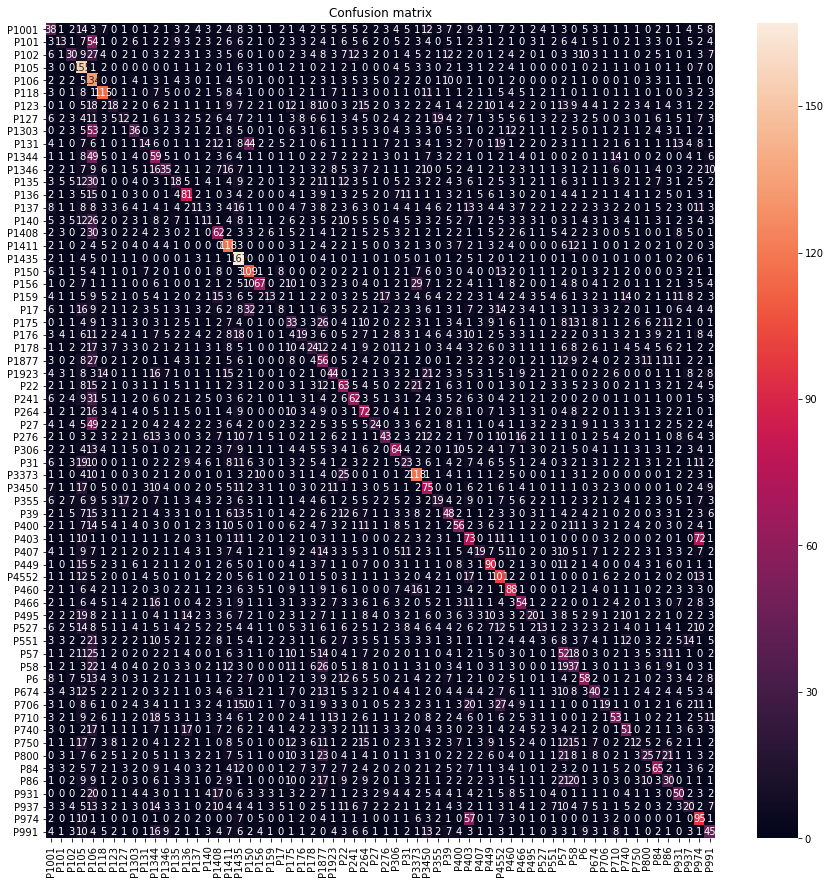

In [227]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Confusion matrix")
plt.show()

Видно, что часто путаемые классы - это, например, Р102 и Р106: "член политической партии" и "занятие (occupation)". Действительно, политическая деятельность члена партии и является его занятием, и предложения с данными сущностями, скорее всего, будут похожи. Сравним, например,  
'George Chapman (?1559-?1634) was a successful playwright' (Р106)  
и  
'Hubert Ney (12 October 1892 – 3 February 1984) was a German politician' (Р102)  
Вполне очевидно, что эти классы легко спутать.

### Статья:  
Batista D. S., Martins B., Silva M. J. Semi-supervised bootstrapping of relationship extractors with distributional semantics  

### Определения  

semantic drift - отличие семантики извлечённых отношений от семантики отношений, составляющих ядро (при бутстрэпинге). 

DIPRE (Dual Iterative Pattern Relation Expansion) - система извлечения отношений, предложенная С. Брином в 1998 г. Была создана для извлечения из текстов из Интернета отношений вида (автор, книга).  

ReVerb - система извлечения бинарных отношений (типа {arg1} is located in {arg2}, {arg1} built {arg2} и т.д.), разработанная в Университете Вашингтона в 2011 году. Данные доступны здесь: http://reverb.cs.washington.edu/  
 
Freebase - графовая база знаний, разработанная компанией Metaweb в 2008 г. Имеет версию FreebaseEasy, из которой можно легко извлечь уникальные имена сущностей и бинарные отношения между ними.